In [141]:
import jax
from position2 import Position2
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy.interpolate
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import functools
import jax.random
from flax.optim.adam import Adam

In [142]:
# class TickTock(object):
#     def __init__(self):
#         self._timers = defaultdict()

# Load SLAM data

In [9]:
# datafile = "/media/mikhail/Data3T/slam_benchmark/intel.clf"
# datafile = "/home/mikhail/Downloads/intel.gfs(4).log" # Corrected intel map
datafile = "/home/mikhail/Downloads/intel.gfs.log"

In [10]:
@dataclass(frozen=True)
class LaserData(object):
    ranges: np.array
    angles: np.array
    timestamp: float
    odometry_position: Position2
        
    def as_points(self):
        mask = self.ranges < 10
        x = self.ranges[mask] * np.cos(self.angles[mask])
        y = self.ranges[mask] * np.sin(self.angles[mask])
        return np.stack([x, y], axis=1)

    def as_points_in_odometry_frame(self):
        points = self.as_points()
        return self.odometry_position.apply(points)

In [11]:
laser_data_list = []
with open(datafile, "r") as fd:
    for line in fd.readlines():
        line = line.strip()
        tokens = line.split(' ')
        if len(tokens) <= 180:
            continue
        num_scans = int(tokens[1])
        ranges = np.array([float(r) for r in tokens[2:(num_scans + 2)]])
        angles = np.linspace(-90.0 / 180.0 * np.pi, 90.0 / 180.0 * np.pi, num_scans + 1)[:-1]
        timestamp = float(tokens[(num_scans + 8)])
        odom_x, odom_y, odom_theta = [float(r) for r in tokens[(num_scans + 2):(num_scans + 5)]]
        position = Position2(odom_x, odom_y, odom_theta)
        laser_data_list.append(LaserData(ranges=ranges, angles=angles, timestamp=timestamp, odometry_position=
                                        position))

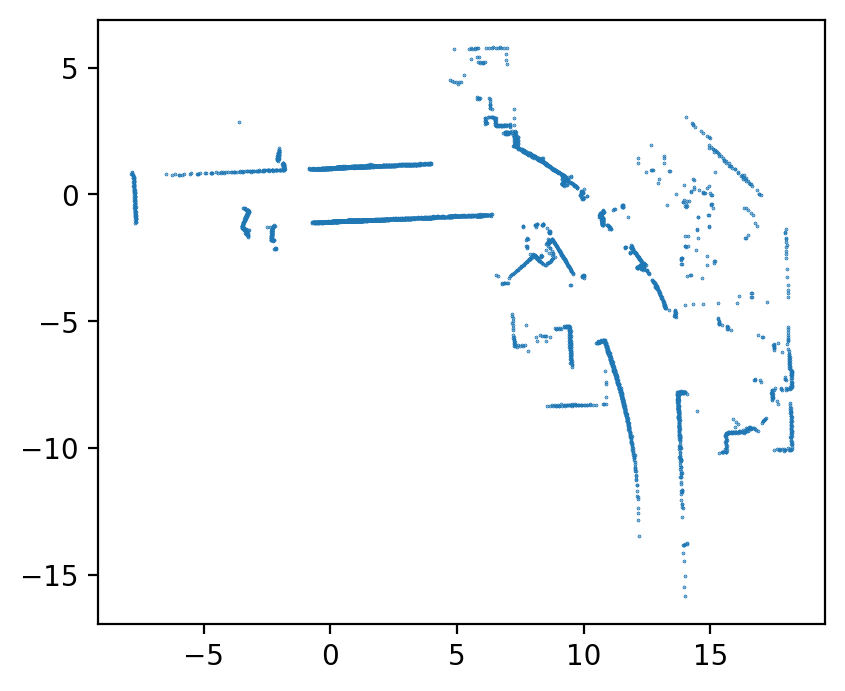

In [925]:
plt.figure(dpi=200)
all_points = []
for laser_data in laser_data_list[:30]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.1)
plt.gca().set_aspect('equal')

## Load ground truth

In [13]:
@dataclass
class StampedTrajectory():
    trajectory: Position2
    times: np.array
    
    def interpolate(times):
        result = scipy.interpolate.interp1d(self.times, self.trajectory, kind="linear", axis=0, 
                                            fill_value="extrapolate")(times)
        return result

# Rendering

In [1082]:
class NFModel(nn.Module):
    mean: float
    sigma: float

    @nn.compact
    def __call__(self, x):
        x = (x - self.mean) / self.sigma
        x = nn.Dense(256)(x)      
        x = jnp.concatenate([jnp.sin(x[:, :128]), jnp.cos(x[:, 128:])], axis=1)
        x1 = x
        x1 = nn.Dense(128)(x1)
        x1 = nn.relu(x1)
        x1 = nn.Dense(128)(x1)
        x1 = nn.relu(x1)
        x1 = nn.Dense(128)(x1)
        x1 = nn.relu(x1)
        x = jnp.concatenate([x, x1], axis=-1)
#         x = nn.Dense(128)(x)
#         x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x[:, 0]


In [1083]:
def plot_model_heatmap(model, variables, bounds, vmax=None, grid_shape=(100, 100)):
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], 100), 
                                  jnp.linspace(bounds[2], bounds[3], 100))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilites = jax.nn.softplus(model.apply(variables, grid))
    obstacle_probabilites = np.array(obstacle_probabilites).reshape(100, 100)
    grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu', shading='auto',
                        vmin=0, vmax=None)
    plt.gca().set_aspect('equal')

In [1084]:
model = NFModel(0, 0.2)
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
output = model.apply(variables, batch)

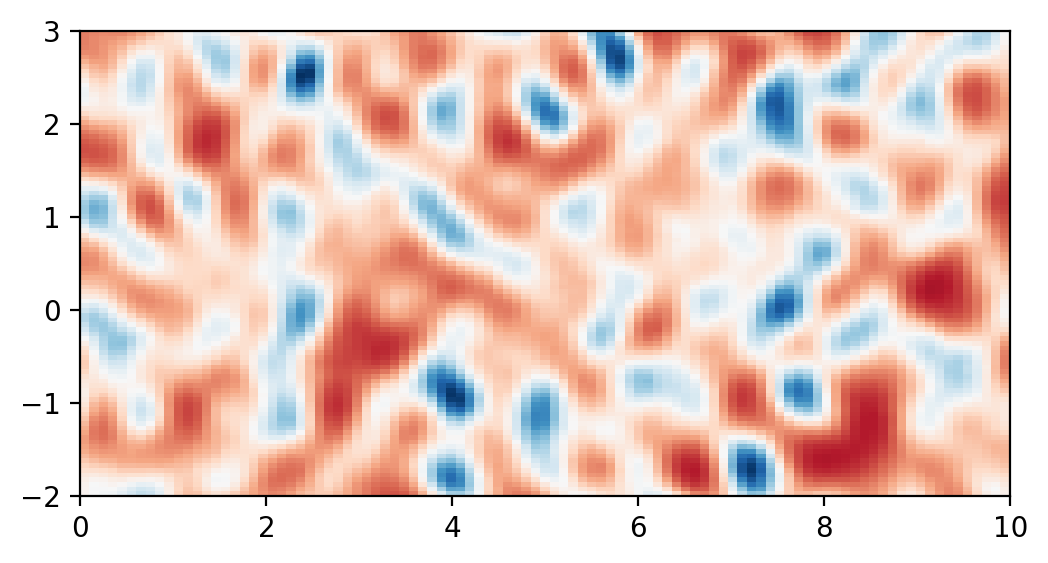

In [1085]:
plt.figure(dpi=200)
plot_model_heatmap(model, variables, (0, 10, -2, 3))

In [1086]:
@dataclass(unsafe_hash=True)
class ModelConfig(object):
    minimal_depth: float
    maximal_depth: float
    bins_count: int
    density_scale: float
    depth_delta: float = field(init=False)
    def __post_init__(self):
        self.depth_delta = (self.maximal_depth - self.minimal_depth) / self.bins_count

In [1108]:
@jax.jit
def calculate_weights(densities, depth_deltas):
    mis_probability = jnp.exp(-densities * depth_deltas)
    hit_probability = 1 - mis_probability
    mis_probability = jnp.concatenate([jnp.ones(1), mis_probability])
    hit_probability = jnp.concatenate([hit_probability, jnp.ones(1)])
    cumproduct = jnp.cumprod(mis_probability)
    weights = cumproduct * hit_probability
    return weights

@functools.partial(jax.jit, static_argnums=1)
def sample_depth_bins(uniform, parameters):
    depths = jnp.linspace(parameters.minimal_depth, parameters.maximal_depth, parameters.bins_count + 1)[:-1]
    depths = depths + parameters.depth_delta * uniform
    return jnp.concatenate([jnp.full([depths.shape[0], 1], parameters.minimal_depth), 
                            depths, 
                            jnp.full([depths.shape[0], 1], parameters.maximal_depth)], axis=-1)

@jax.jit
def transform_points(points, x, y, angle):
    transformed_x = x + points[..., 0] * jnp.cos(angle) - points[..., 1] * jnp.sin(angle)
    transformed_y = y + points[..., 0] * jnp.sin(angle) + points[..., 1] * jnp.cos(angle)
    return jnp.stack([transformed_x, transformed_y], axis=-1)


def calculate_points(depths, angles):
    x = depths * jnp.cos(angles[..., None])
    y = depths * jnp.sin(angles[..., None])
    return jnp.stack([x, y], axis=-1)
    
@functools.partial(jax.jit, static_argnums=7)
def loss_function(variables, truth_depths, angles, uniform, x, y, angle, config):
    depth_bins = sample_depth_bins(uniform, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, angles).reshape(-1, 2)
    points = transform_points(points, x, y, angle)
    densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    predicted_variance = jnp.sum(weights * (extended_depths - predicted_depths[..., None]) ** 2, axis=-1)
    return jnp.mean((truth_depths - predicted_depths) ** 2 / jax.lax.stop_gradient(predicted_variance))
#     return jnp.mean((truth_depths - predicted_depths) ** 2)
#     return  jnp.mean((truth_depths - predicted_depths) ** 2 / (jax.lax.stop_gradient(predicted_variance) + 1e-3) +
#                      0.5 * jnp.log(predicted_variance + 1e-3))
#     return  jnp.mean((truth_depths - predicted_depths) ** 2 / (predicted_variance + 1e-3) +
#                      0.5 * jnp.log(predicted_variance + 1e-3))
#     return jnp.mean((truth_depths - predicted_depths) ** 2 / (jax.lax.stop_gradient(predicted_variance) + 1e-3) +
#                    0 * predicted_variance)

## Test loss

In [1109]:
config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=40,
    density_scale=10
)
loss_function(variables, truth_depths=jnp.ones(config.bins_count), angles=jnp.ones(config.bins_count), 
     uniform=jnp.ones([config.bins_count, config.bins_count]),
              x=1, y=1,
              angle=1, config=config)

DeviceArray(40935.73, dtype=float32)

In [1110]:
index = 6
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
loss_function(variables, depths, angles, uniform, x, y, angle, config)

DeviceArray(0.26750958, dtype=float32)

In [1111]:
iterations = 100
index = 6
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
grad_function = jax.grad(loss_function)
state = optimizer.init_state(variables)
optimizer = Adam(5e-3, beta1=0.9, beta2=0.8)
losses = []
for i in range(iterations):
    uniform = jax.random.uniform(jax.random.PRNGKey(i), (len(depths), config.bins_count))
    grad = grad_function(variables, depths, angles, uniform, x, y, angle, config)
    loss = loss_function(variables, depths, angles, uniform, x, y, angle, config)
    losses.append(loss)
    variables, state = optimizer.apply_gradient(optimizer.hyper_params, variables, state, grad)
losses[-1]

DeviceArray(0.00501769, dtype=float32)

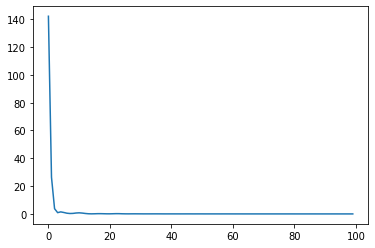

In [1112]:
plt.plot(losses)

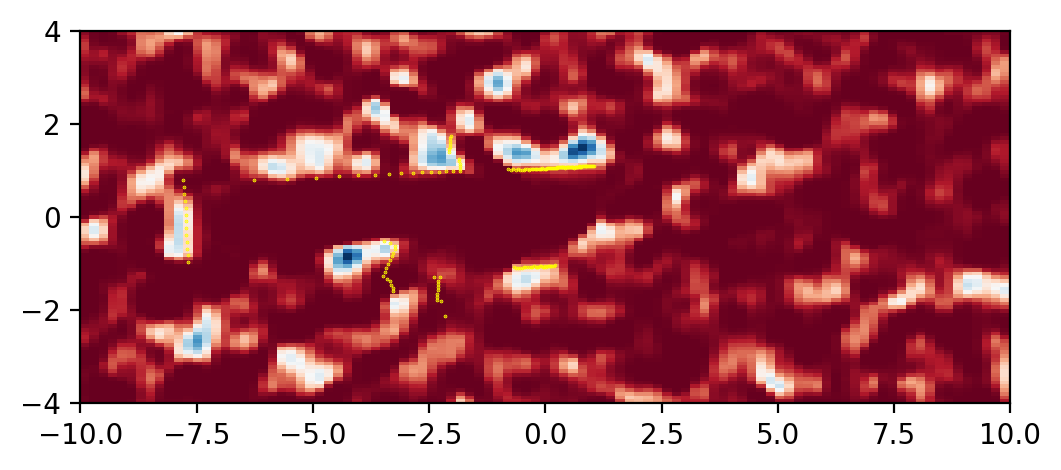

In [1113]:
plt.figure(dpi=200)
plot_model_heatmap(model, variables, (-10, 10, -4, 4))
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.1, c="yellow")
plt.gca().set_aspect('equal')

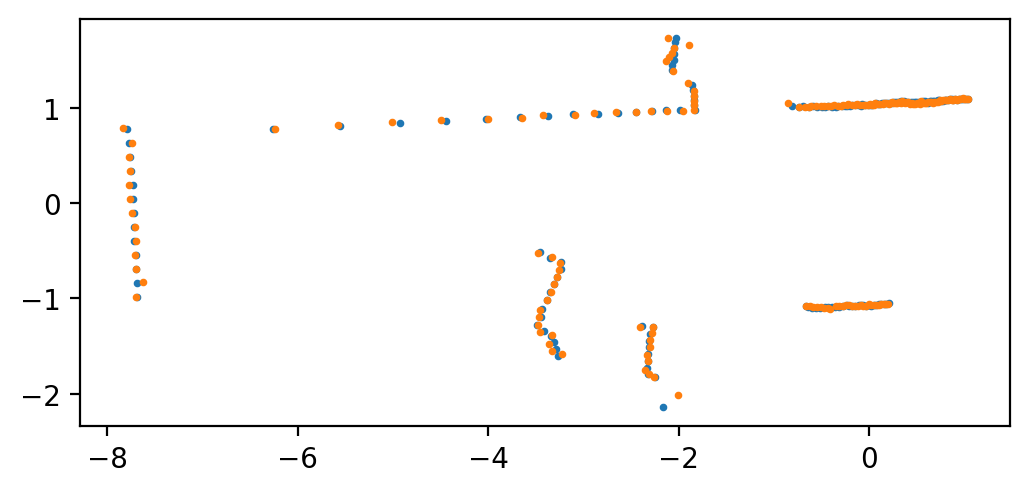

In [1115]:
plt.figure(dpi=200)
laser_data = laser_data_list[index]
# depths = jnp.array(laser_data.ranges)
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(3), (len(depths), config.bins_count))
# uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
depth_bins = sample_depth_bins(uniform, config)
depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
points = calculate_points(depths, angles).reshape(-1, 2)
points = transform_points(points, x, y, angle)
densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
weights = jax.vmap(calculate_weights)(densities, depth_deltas)
extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
measurement_points = np.concatenate(all_points, axis=0)
plt.scatter(measurement_points[:, 0], measurement_points[:, 1], s=3)
plt.gca().set_aspect('equal')
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)

## Run on several scans

In [1116]:
iterations = 20 * 8
laser_data_indeces = np.repeat(np.arange(100)[:, None], 20, axis=1).reshape(-1)
batch = jnp.ones([20, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
grad_function = jax.grad(loss_function)
state = optimizer.init_state(variables)
optimizer = Adam(1e-2, beta1=0.9, beta2=0.8, weight_decay=0.1)
# optimizer = Adam(5e-3, beta1=0.9, beta2=0.8)
losses = []
for i in range(iterations):
    laser_data = laser_data_list[laser_data_indeces[i]]
    mask = laser_data.ranges < 10
    depths = jnp.array(laser_data.ranges[mask])
    angles = jnp.array(laser_data.angles[mask])
    uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
    x = laser_data.odometry_position.x
    y = laser_data.odometry_position.y
    angle = laser_data.odometry_position.rotation
    uniform = jax.random.uniform(jax.random.PRNGKey(i), (len(depths), config.bins_count))
    grad = grad_function(variables, depths, angles, uniform, x, y, angle, config)
    loss = loss_function(variables, depths, angles, uniform, x, y, angle, config)
    losses.append(loss)
    variables, state = optimizer.apply_gradient(optimizer.hyper_params, variables, state, grad)
losses[-1]

DeviceArray(0.17460752, dtype=float32)

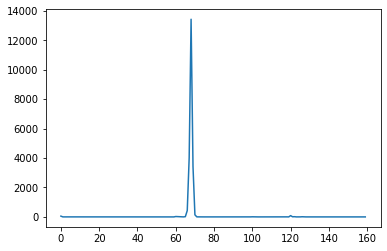

In [1117]:
plt.plot(losses)

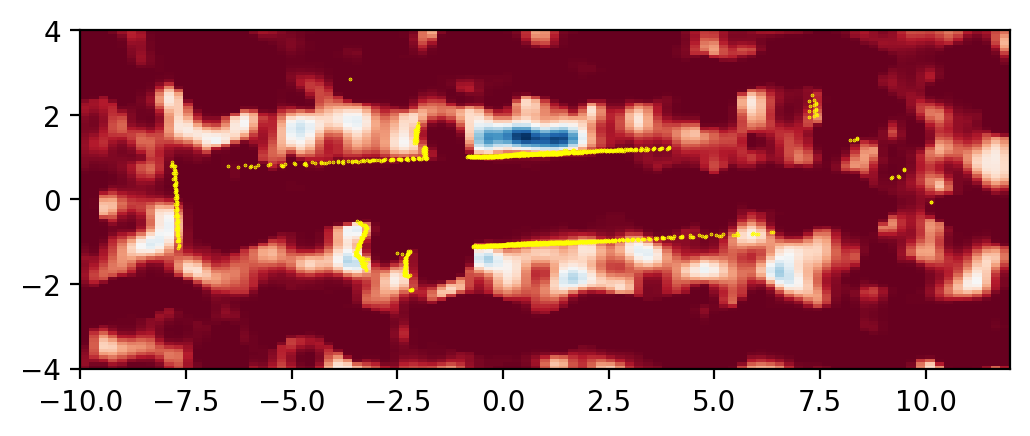

In [1102]:
plt.figure(dpi=200)
plot_model_heatmap(model, variables, (-10, 12, -4, 4))
all_points = []
for laser_data in laser_data_list[:10]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.1, c="yellow")
plt.gca().set_aspect('equal')

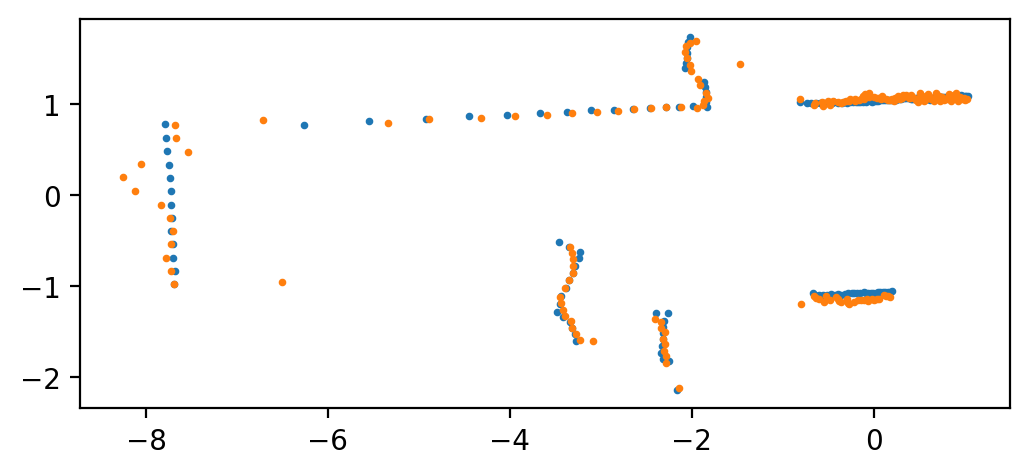

In [1118]:
plt.figure(dpi=200)
index = 6
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
# depths = jnp.array(laser_data.ranges)
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(2), (len(depths), config.bins_count))
# uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
depth_bins = sample_depth_bins(uniform, config)
depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
points = calculate_points(depths, angles).reshape(-1, 2)
points = transform_points(points, x, y, angle)
densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
weights = jax.vmap(calculate_weights)(densities, depth_deltas)
extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
measurement_points = np.concatenate(all_points, axis=0)
plt.scatter(measurement_points[:, 0], measurement_points[:, 1], s=3)
plt.gca().set_aspect('equal')
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)